# Face Emotions Recognise
#### Python notebook used to generate and test the final CNN used by app

In [ ]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import cv2

from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mlxtend.plotting import plot_confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
path_dataset = './datasets/fer2013.csv'

In [ ]:
data = pd.read_csv(path_dataset)
data.head()

Show the size of dataset and the number of records per emotion

In [ ]:
print(f"The size of dataset is {len(data)}")
print(f"The number of records per emotion:\n {data['emotion'].value_counts()}")

Map all the emotions in the dataset with real values

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

def print_predicted_cmap():
  test_prob = model.predict(test_images)
  test_pred = np.argmax(test_prob, axis=1)

  sel_imgs = [10, 15, 26, 12, 64, 14, 9]

  for n in sel_imgs:
    img = test_data[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[test_labels[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='RdBu_r')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='steelblue', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()

##### Split dataset into Train, Validation and Test

In [ ]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48,1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48,1))
        image = image / 255.0
        image_array[i] = image
        
    return image_array, image_label

In [ ]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

In [ ]:
train_images, valid_images, train_labels, valid_labels = train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

### Model

Model declaration and summary

In [ ]:
input_reshape = (48, 48, 1)

strides = (2, 2)
pool_size = (2, 2)
kernel_size = (3, 3)

epochs = 30
batch_size = 256

model = Sequential()

model.add(Conv2D(128, kernel_size=kernel_size, activation='relu', padding='same', input_shape=input_reshape))
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Conv2D(128, kernel_size=kernel_size, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 12, 12, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 128)      5

Fit model using Adam as Optimizer and compile that with loss = `sparse_categorical_crossentropy`

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
h1 = model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data =(valid_images, valid_labels)) 


#### Show results of CNN

Definition of functions used to show result achived by the CNN

Function used to plot the Train Accuracy compared to Validation Accuracy and the Training Loss compared to Validation Loss

In [ ]:
def plot_model_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

Function used to show the confusion matrix of model and evaluate its overall accuracy

In [ ]:
def print_cf_matrix():
  test_prob = model.predict(test_images)
  test_pred = np.argmax(test_prob, axis=1)
  test_accuracy = np.mean(test_pred == test_labels)

  print(test_accuracy)

  conf_mat = confusion_matrix(test_labels, test_pred)

  pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

  fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                  show_normed=True,
                                  show_absolute=False,
                                  figsize=(8, 8))
  fig.show()

Function used to show the activation region, on image, used by the CNN to make the prediction

In [ ]:
def print_color_map():
  plt.figure(figsize=[16,16])
  for i in range(36):
    img = test_images[i,:,:,0]
    p_dist = model.predict(img.reshape(1,48,48,1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))

    plt.subplot(6,6,i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='coolwarm')
    plt.title(f'{emotions[test_labels[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
plot_model_history(h1)
print_cf_matrix()
print_color_map()

#### Export model to JSON

Now we need to export model and his weights in json format. This allow the final React Native application to used it

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'models')

In [ ]:
weights_list = model.get_weights()
weights_list_json = weights_l

In [ ]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# serialize weights to hdf5
model.save_weights("model.bin")

In [ ]:
import coremltools 
coreml_model = coremltools.converters.keras.convert('fimal_model.h5',
                                                                        input_names='image',
                                                                        image_input_names='image', 
                                                                        output_names='grid',
                                                                        image_scale=1/255)

In [ ]:
import os
os.path.getsize('/content/converted_model.tflite') >> 20 

5

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

In [ ]:
def predict_input(images):
    predictions = model.predict(images)
    for p in predictions:
      emotion_analysis(p)

    plt.show()

In [ ]:
def predict_from_webcam(x):
  new_image_array = np.zeros(shape=(1,48,48))
  x = np.reshape(x,(48,48))
  new_image_array[0] = x
  new_predict_images = new_image_array.reshape((new_image_array.shape[0], 48, 48, 1))
  #arr_to_predict = new_image_array.astype('float32')/255
  predict_input(new_predict_images)

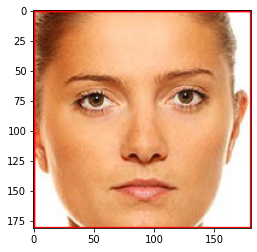

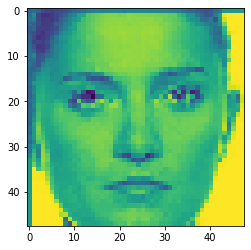

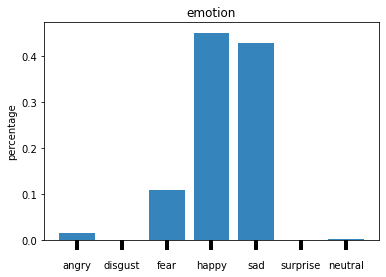

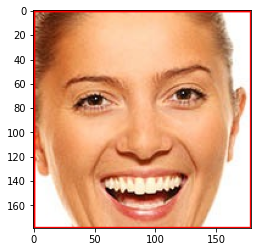

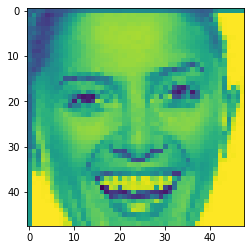

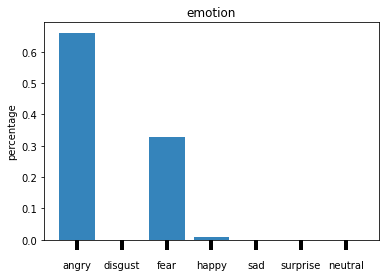

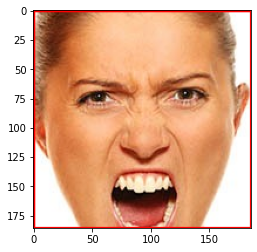

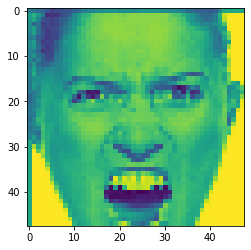

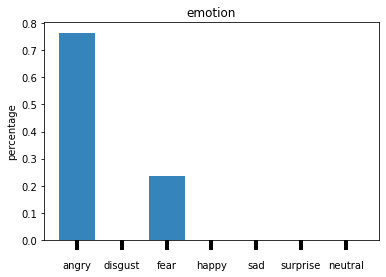

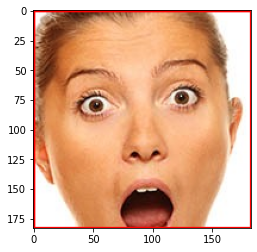

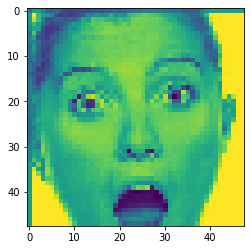

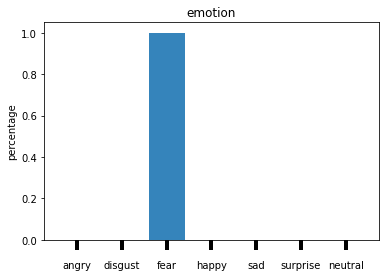

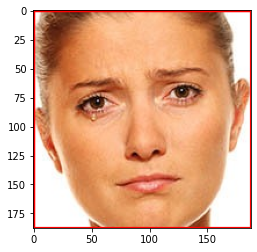

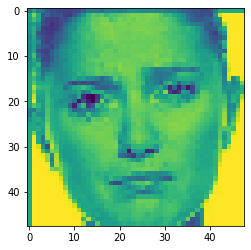

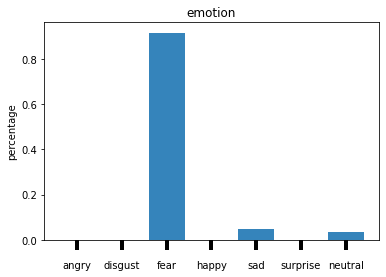

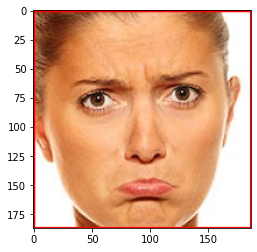

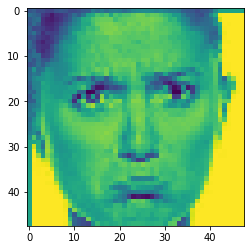

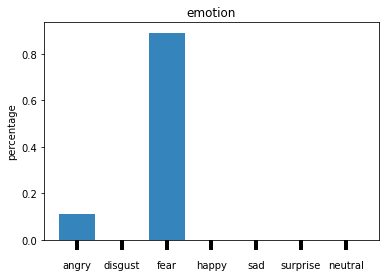

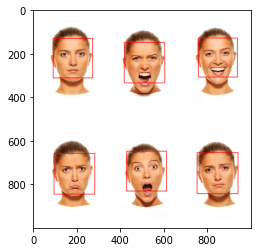

In [ ]:
import tensorflow.keras as keras
path = '/content/face_emotions_static_test.jpeg'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Sistemi Digitali M/haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
  img = image[y : y+w, x:x+w]
  plt.imshow(img)
  plt.show()
  img = keras.applications.mobilenet_v2.preprocess_input(img)
  img = cv2.resize(img,(48,48))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  plt.imshow(img)
  plt.show()
  predict_from_webcam(img)

plt.imshow(image)
plt.show()